In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

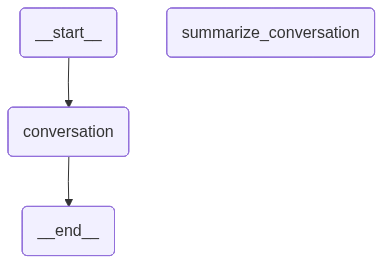

In [3]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

# streaming full state

In [4]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Shree")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello Shree! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 12, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CVK6qI5tPbh8tzKL1dIiiEu5JvPID', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--900cf1f5-eb56-44bf-9d3d-52b683831830-0', usage_metadata={'input_tokens': 12, 'output_tokens': 11, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [5]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Shree")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello Shree! How are you today? Is there anything specific you'd like to talk about or need help with?


In [6]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm  Shree")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm  Shree
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm  Shree
================================== Ai Message ==================================

Hello Shree! How can I assist you today?
---------------------------------------------------------------------------


# Streaming tokens

In [7]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the first world war")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

In [8]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the first world war")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--1f13722d-1068-4e04-ab7f-74b5e6900ea7')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--1f13722d-1068-4e04-ab7f-74b5e6900ea7')}
{'chunk': AIMessageChunk(content=' First', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--1f13722d-1068-4e04-ab7f-74b5e6900ea7')}
{'chunk': AIMessageChunk(content=' World', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--1f13722d-1068-4e04-ab7f-74b5e6900ea7')}
{'chunk': AIMessageChunk(content=' War', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--1f13722d-1068-4e04-ab7f-74b5e6900ea7')}
{'chunk': AIMessageChunk(content=',', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--1f13722d-1068-4e04-ab7f-74b5e6900ea7')}
{'chunk': AIMessageChunk(c

In [10]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the frist world war")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="||")

||The|| First|| World|| War||,|| also|| known|| as|| World|| War|| I|| or|| the|| Great|| War||,|| was|| a|| major|| global|| conflict|| that|| took|| place|| from|| July|| ||28||,|| ||191||4||,|| to|| November|| ||11||,|| ||191||8||.|| It|| involved|| many|| of|| the|| world's|| great|| powers||,|| which|| were|| divided|| into|| two|| main|| alliances||:|| the|| Allies|| and|| the|| Central|| Powers||.

||###|| Causes||:
||1||.|| **||Ass||ass||ination|| of|| Arch||du||ke|| Franz|| Ferdinand||**||:|| The|| immediate|| trigger|| for|| the|| war|| was|| the|| assassination|| of|| Arch||du||ke|| Franz|| Ferdinand|| of|| Austria||-H||ung||ary|| by|| Gav||r||ilo|| Princip||,|| a|| Bos||nian|| Ser||b|| nationalist||,|| in|| Sarajevo|| on|| June|| ||28||,|| ||191||4||.
||2||.|| **||Alliance|| System||**||:|| Europe|| was|| divided|| into|| two|| main|| alliances||:|| the|| Triple|| Ent||ente|| (||com||prising|| France||,|| Russia||,|| and|| the|| United|| Kingdom||)|| and|| the|| Triple|| Al

in langgraph studio 

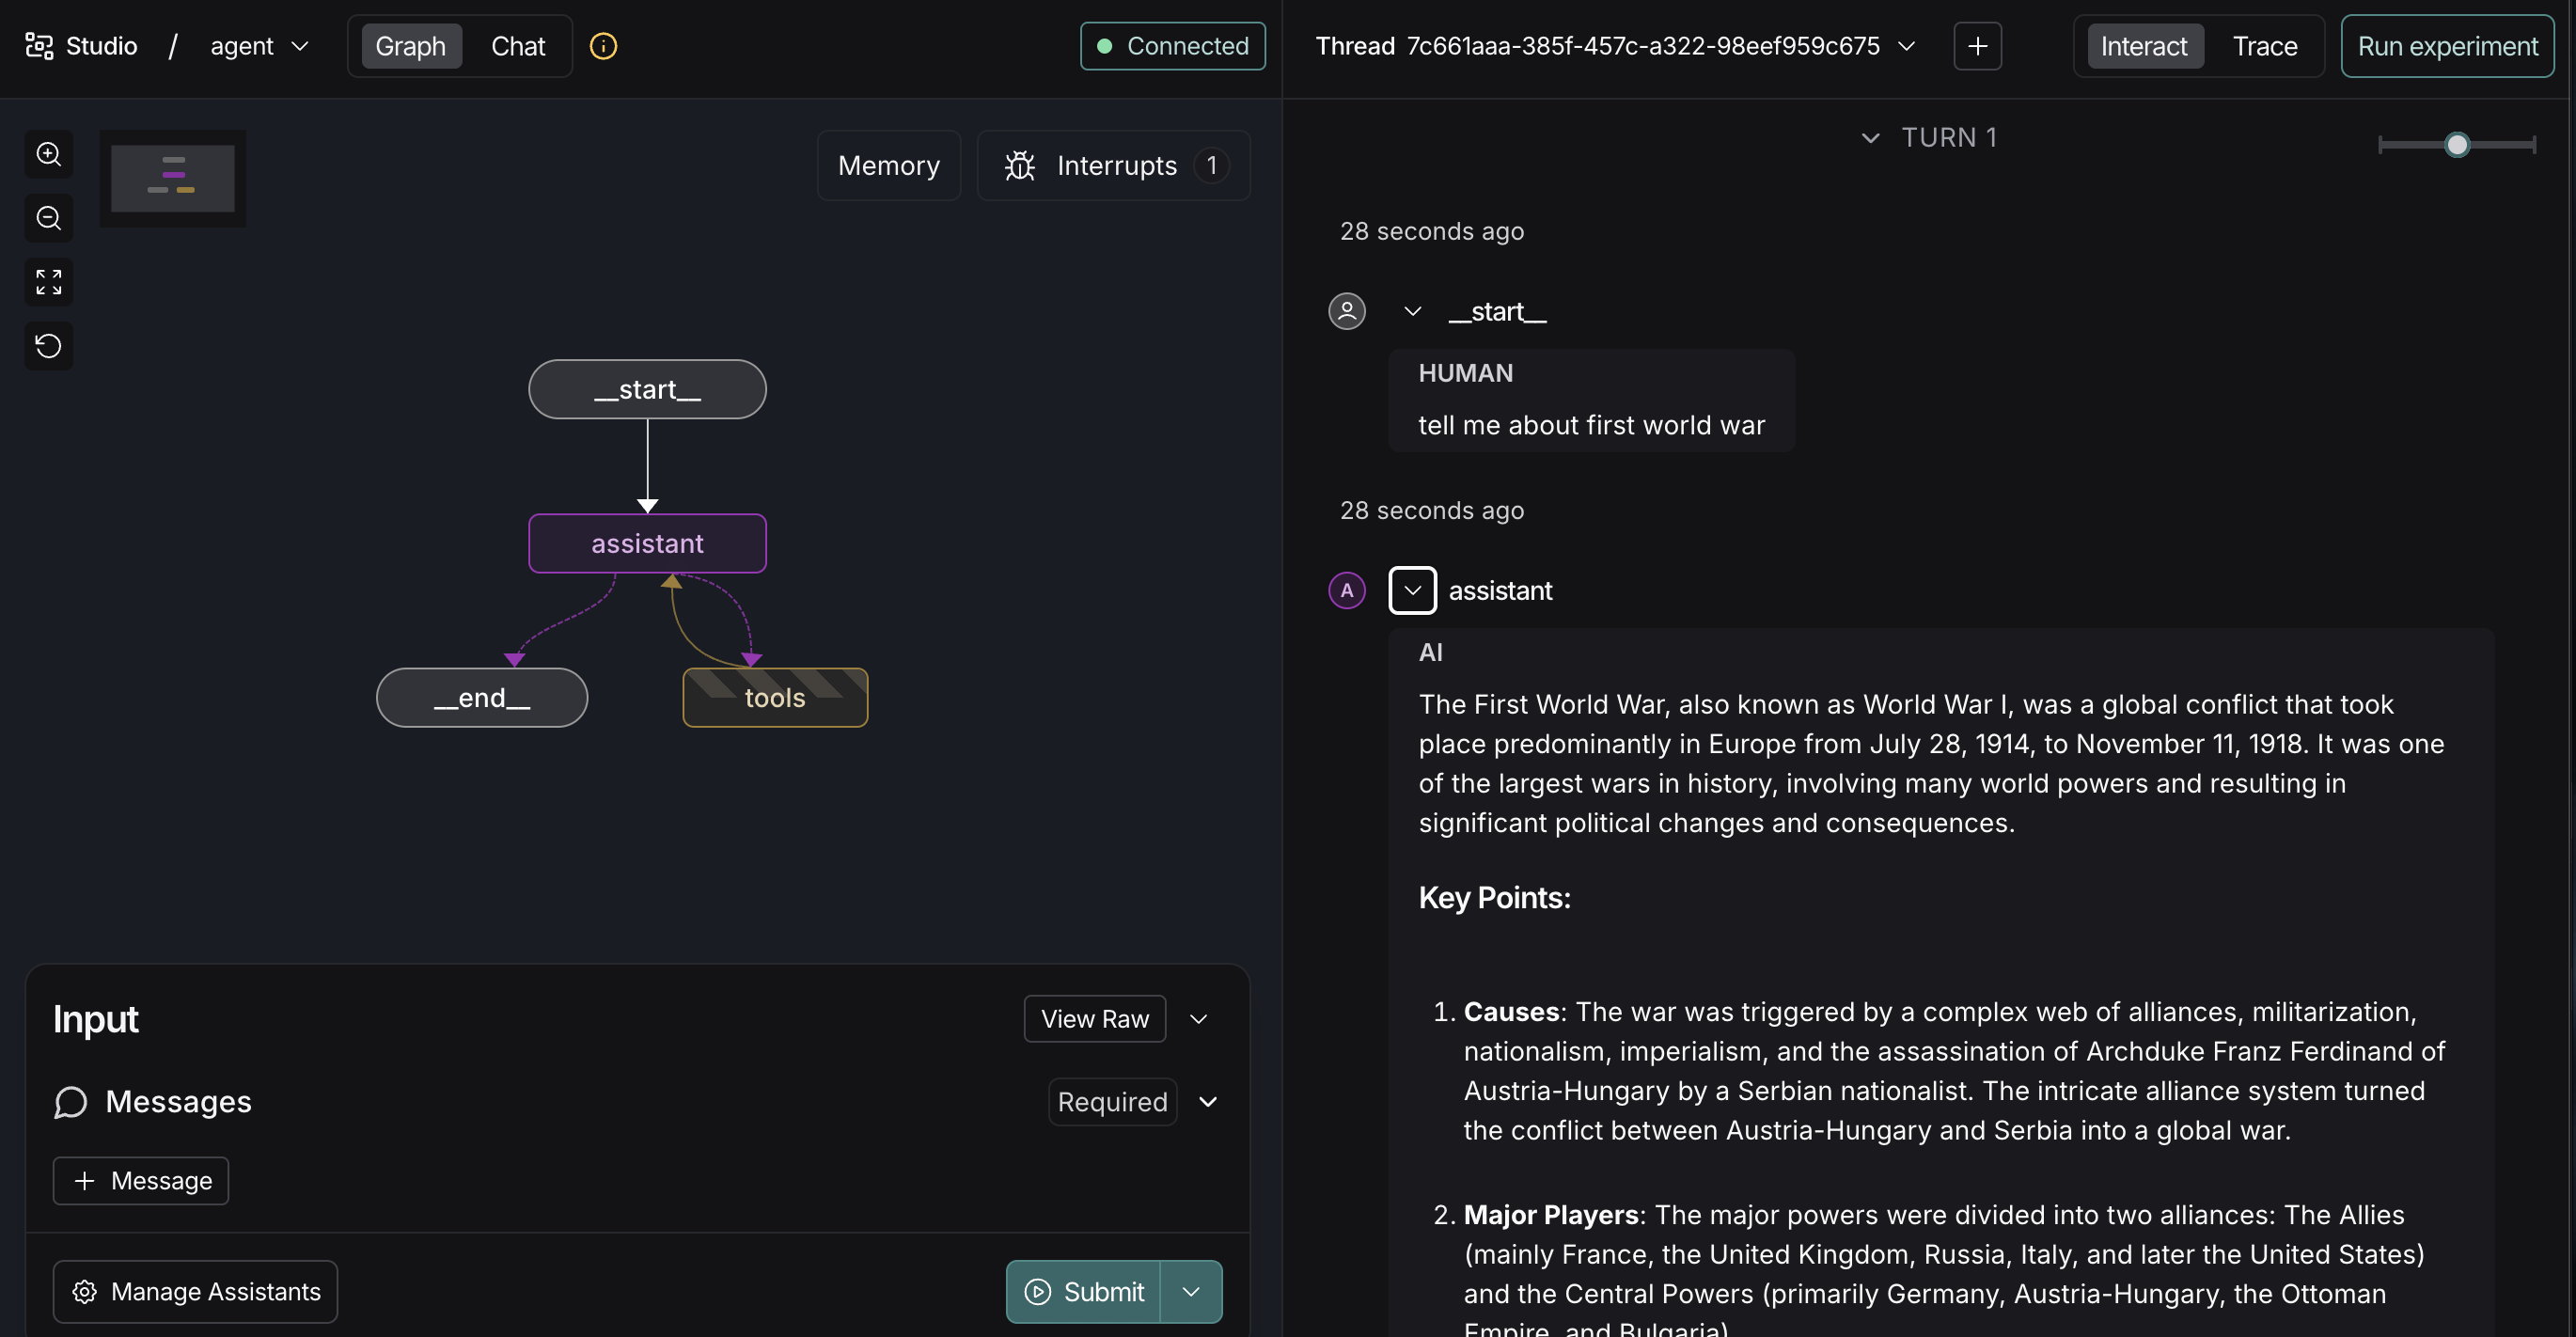

In [11]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [13]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="best place to visit in india")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '019a2676-c875-7282-bd83-1dd03bf5590f', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'best place to visit in india', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '7f922779-25de-4a04-96dc-86cc8d77b10f'}]})
StreamPart(event='values', data={'messages': [{'content': 'best place to visit in india', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '7f922779-25de-4a04-96dc-86cc8d77b10f'}, {'content': "India is a vast country with a rich cultural heritage, diverse landscapes, and numerous attractions. The best place to visit depends on your interests, but here are some popular destinations across different regions:\n\n1. **Agra** - Home to the iconic Taj Mahal, a UNESCO World Heritage Site and a symbol of India's rich history.\n\n2. **Jaipur** - Known as the Pink City, Jaipur is famous for its historic palaces and forts, such as the Amber Fort

In [14]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="est place to visit in india")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='est place to visit in india' additional_kwargs={} response_metadata={} id='80e18430-6635-40ff-a4ee-e78fa2fd0d4b'
content="India is a diverse and culturally rich country with numerous amazing places to visit. Here are some of the most popular destinations:\n\n1. **Taj Mahal, Agra**: Known as a symbol of love, this stunning white marble mausoleum is one of the Seven Wonders of the World.\n\n2. **Jaipur, Rajasthan**: Known as the Pink City, Jaipur is famous for its historic palaces, forts, and vibrant culture.\n\n3. **Kerala Backwaters**: A network of serene canals and lagoons that offer a unique and tranquil experience.\n\n4. **Varanasi, Uttar Pradesh**: One of the world's oldest inhabited cities, Varanasi is a spiritual hub for Hinduism.\n\n5. **Goa**: Popular for its beautiful beaches, vibrant nightlife, and Portuguese heritage.\n\n6. **Ladakh**: Known for its stunning landscapes, monasteries, and adventure activities.\n\n7. **Ranthambore National Park**: A prime location for 

In [15]:
thread = await client.threads.create()
input_message = HumanMessage(content="best place to visit in india")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
mess

In [16]:
thread = await client.threads.create()
input_message = HumanMessage(content="Best place to visit in india")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 019a2678-735c-7470-b199-afe2fc505711
--------------------------------------------------
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: India
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: India offers
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: India offers a
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: India offers a rich
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: India offers a rich tapestry
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: India offers a rich tapestry of
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: India offers a rich tapestry of destinations
Response Metadata: Finish Reason - N/A
------------------------------------